<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Filter**

Welcome to RAFT Filter! In this notebook, we will learn how to filter Optical Flow estimations in both space (spatial) and time (temporal)

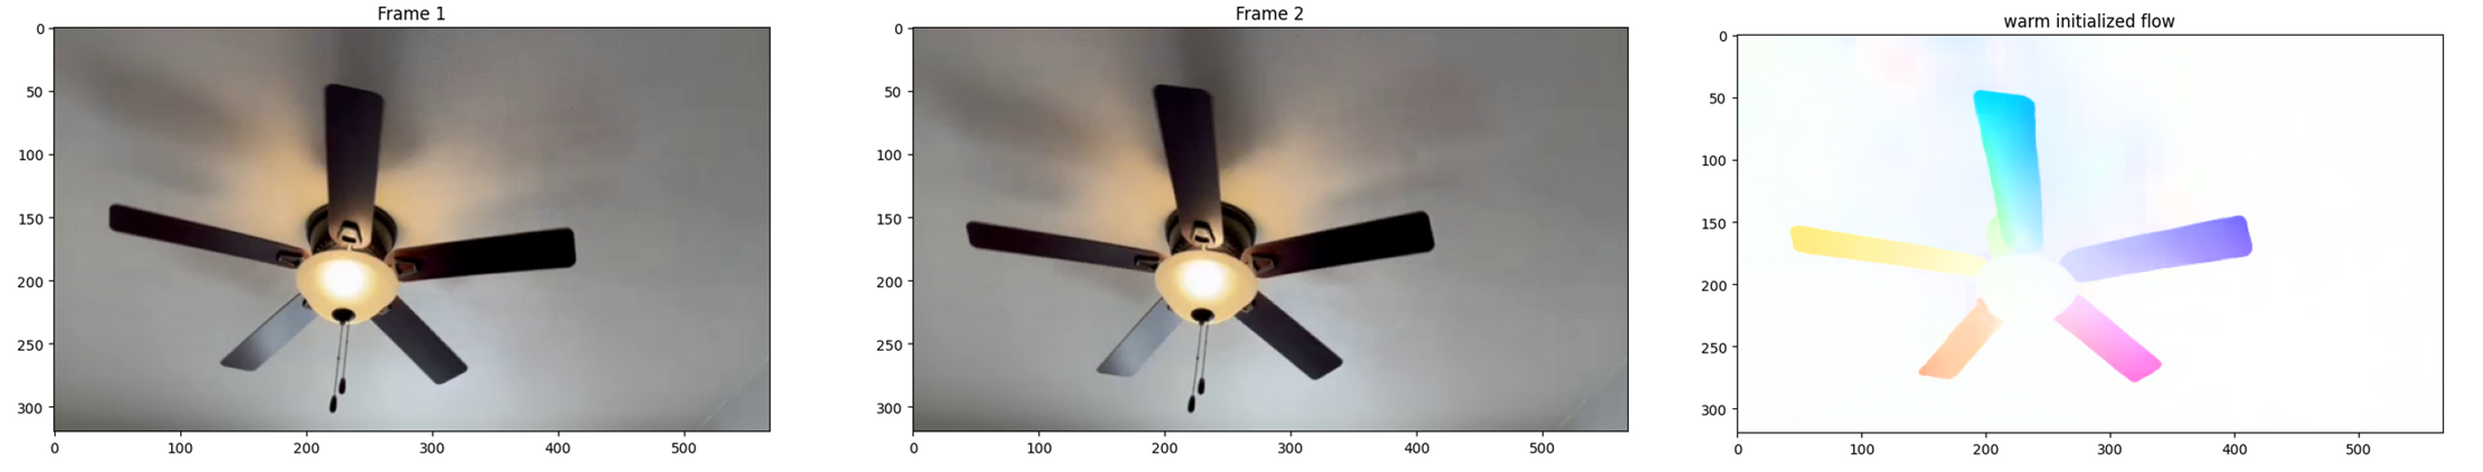

Get RAFT

In [ ]:
!git clone https://github.com/princeton-vl/RAFT.git

Get Helper functions

In [ ]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/raft_utils.py

In [ ]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# add RAFT core to the path
sys.path.append('RAFT/core')

from raft_utils import *

### Get Data

In [ ]:
# !wget https://raw.githubusercontent.com/itberrios/CV_projects/main/fan.MOV

In [ ]:
# video = cv2.VideoCapture("fan.MOV")

# if (video.isOpened() == False):
#     print("Error opening video file")

# # get frame rate
# fps = video.get(cv2.CAP_PROP_FPS)

# frames = []
# while(video.isOpened()):

#     # read each video frame
#     ret, frame = video.read()

#     if ret == True:
#         frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#     # Break if nothing is returned
#     else:
#         break

# # clean up
# video.release()
# cv2.destroyAllWindows()
# del video

Get individual frames from smaller video

In [ ]:
import subprocess

env = os.environ.copy()
frame_paths = []
for i in range(75):
    cmd = f"wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_{i}.png"
    subprocess.run(cmd, shell=True, env=env)

    frame_paths.append(f"fan_frame_{i}.png")

In [ ]:
frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

### Download Models

In [ ]:
%cd RAFT
!./download_models.sh
%cd ..

### Load Model

In [ ]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# **Run RAFT on Sequence of Images**

In this section we will run RAFT on the fan image sequence

In [ ]:
# store results
unfiltered_flow_frames = []

for i in range(2, len(frame_paths)):
    # get frames
    frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2RGB)
    frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2RGB)
    frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)

    # get previous estimate at 1/8 res
    flow_lo, flow_up = inference(model, frame_1, frame_2, device='cuda', pad_mode=None, iters=20, test_mode=True)

    # 0 initialization
    flow_lo_cold, flow_up_cold = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

    # warm initialization
    flow_lo_warm, flow_up_warm = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

    # save results
    if i == 2:
      unfiltered_flow_frames.append(flow_up)

    unfiltered_flow_frames.append(flow_up_warm)

In [ ]:
idx = 70

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
warm = unfiltered_flow_frames[idx].clone()

_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(og_frame)
ax[0].set_title('Original frame')
ax[1].imshow(get_viz(warm))
ax[1].set_title('Optical Flow from Unfiltered frames');

# **Spatial Filtering**

The goal of this section is to remove the noise in the flow estimates, if you notice in the unfiltered estimates above, there is almost always some distorted flow that is erroenously being estimated. This extra noise could be due to the background shadows and lighting, but it could also be hallucinated from the network. Using classical methods such as Farenbecks don't seem to have this problem, but they can not estimate the flow to the same fidelity as RAFT. We will attempt to remove this noise with some simple Spatial Filtering, before and poaaibly after the flow estimation.

<br>

Below is the code to filter the images before we estimate the flow, we are simply bluring, edge sharpening, and then bluring again for a set number of iterations. We also remove very small values (less than 10) as another way of reducing noise. We will see below that this method is able to extract the main parts of the image, removing most of the noise. We will also notice that the filtering is not perfect since it introduces small artifacts that are hard to get rid of.

As an alternative, we can use the Canny Edge detector, but it doesn't seem to work as well.

In [ ]:
def filter_image(frame, iters=1):

    filtered = frame.copy()

    for i in range(iters):
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(3,3), sigmaX=3)
      filtered = cv2.Laplacian(filtered, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(5,5), sigmaX=5)
      filtered[filtered < 10] = 0
      filtered = cv2.convertScaleAbs(filtered, dst=None, alpha=10, beta=0)

    return filtered


# alternative is to get Canny Edges but it doesnt seem to work well
def canny_filter(frame):
    frame = cv2.Canny(frame, 50, 150, apertureSize=3)
    frame = cv2.dilate(frame, kernel=(31,31), iterations=10)

    return frame

In [ ]:
# store results
cold_flow_frames = []
flow_frames = []

for i in range(2, len(frame_paths)):
    # get frames
    frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2GRAY)
    frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2GRAY)

    # Filter
    frame_1 = filter_image(frame_1, iters=2)
    frame_2 = filter_image(frame_2, iters=2)
    frame_3 = filter_image(frame_3, iters=2)

    # repeat last 3 dimensions
    frame_1 = np.repeat(frame_1[:, :, None], 3, axis=-1)
    frame_2 = np.repeat(frame_2[:, :, None], 3, axis=-1)
    frame_3 = np.repeat(frame_3[:, :, None], 3, axis=-1)

    # get previous estimate at 1/8 res
    flow_lo, flow_up = inference(model, frame_1, frame_2, device='cuda', pad_mode=None, iters=20, test_mode=True)

    # 0 initialization
    flow_lo_cold, flow_up_cold = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

    # warm initialization
    flow_lo_warm, flow_up_warm = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

    # save results
    if i == 2:
      flow_frames.append(flow_up)
      cold_flow_frames.append(flow_up)

    flow_frames.append(flow_up_warm)
    cold_flow_frames.append(flow_up_cold)


Display results, this time we will filter small values from the flow estimates. Try different values for 'thresh' and see how it impacts the flow estimates

In [ ]:
# filter results
idx = 70
thresh = 2

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame, iters=2)

cold = cold_flow_frames[idx].clone()
cold[torch.abs(cold) < thresh] = 0

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < thresh] = 0

f, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(cold))
ax[1].set_title('0 initialized flow')
ax[2].imshow(get_viz(warm))
ax[2].set_title('warm initialized flow');

Now let's visualize everything

In [ ]:
idx = 70
thresh = 2

un_flow = unfiltered_flow_frames[idx].clone()

flow = flow_frames[idx].clone()
flow[torch.abs(flow) < thresh] = 0

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].imshow(og_frame)
ax[0, 0].set_title('Original frame')
# ax[0, 0].axis(False)

ax[0, 1].imshow(frame)
ax[0, 1].set_title('Filtered frame')
# ax[0, 1].axis(False)

ax[1, 0].imshow(get_viz(un_flow))
ax[1, 0].set_title('Unfiltered Optical Flow');
# ax[1, 0].axis(False);

ax[1, 1].imshow(get_viz(flow))
ax[1, 1].set_title('Filtered Optical Flow');
# ax[1, 1].axis(False);

We see that the warm initialized flow seems to perform a bit better so we will use that moving forward. Now let's make a GIF of what we have, this will allow us to get better insight of the benefits of Spatial Filtering.

In [ ]:
from PIL import Image
from glob import glob


def create_gif_from_images(save_path, image_path, ext):
    ''' creates a GIF from a folder of images
        Inputs:
            save_path (str) - path to save GIF
            image_path (str) - path where images are located
            ext (str) - extension of the images
        Outputs:
            None

        Update:
            Add functionality for multiple extensions
    '''
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))

    pil_images = [Image.open(im_path ) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

In [ ]:
thresh = 2


for i in range(len(flow_frames)):

    un_flow = unfiltered_flow_frames[i].clone()
    un_flow[torch.abs(un_flow) < thresh] = 0

    flow = flow_frames[i].clone()
    flow[torch.abs(flow) < thresh] = 0

    og_frame = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)
    frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
    frame = filter_image(frame)
    frame = filter_image(frame)

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    ax[0, 0].imshow(og_frame)
    ax[0, 0].set_title('Original frame')
    ax[0, 0].axis(False)

    ax[0, 1].imshow(frame)
    ax[0, 1].set_title('Filtered frame')
    ax[0, 1].axis(False)

    ax[1, 0].imshow(get_viz(un_flow))
    ax[1, 0].set_title('Unfiltered Optical Flow');
    ax[1, 0].axis(False);

    ax[1, 1].imshow(get_viz(flow))
    ax[1, 1].set_title('Filtered Optical Flow');
    ax[1, 1].axis(False);

    fig.savefig(f"flow_gif_{i}.jpg");
    plt.close();

In [ ]:
gif_frame_paths = sorted(glob('*.jpg'))
gif_frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
gif_path = 'flow_spatial.gif'

In [ ]:
pil_images = [Image.open(im_path) for im_path in gif_frame_paths]
pil_images[0].save(gif_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

# **Retroactive Temporal Fitlering**

In this section we will apply a different type of filtering to reduce noise. Even after the spatial filtering we still have noisy areas of optical flow that pop-up on our image, we can reduce this noise with a time based filter. If we notice in the gif we previously made, there are still some intermittent erranous flow estimates that pop up. It would be nice if we could remove this, here's how we will do it.


We will take a single flow estimate and compare it (pixelwise) with a set number of previous and future flow estimates, we will call these the neighboring flow estimates. This will allow us to determine if a given flow estimate makes sense or if it's an outlier. For example if a pixel has a flow of (25, 10) and in the previous and future estimates, the flow at this pixel is very close to 0, the flow at this pixel might be a local outlier since it's value is very different from the pixels in the neighboring flow estimates. If we can find a way to detect local outliers and replace them with a reasonable value, then we can remove the spontanously occuring noise in the flow estimates

<br>

The formal method we will use is called a Hampel Filter, which is actuall intended to remove strong local outliers!

<br>

Let's see an example in 1D to get a better understanding of the Hampel filter!

In [ ]:
fs = 100
t = np.arange(0, np.pi, 1/fs)
x = np.sin(2*np.pi*t)

# add random impulses on signal
x_noisy = x.copy()
locs = np.random.choice(np.arange(0, len(t)), size=25)
x_noisy[locs] += 0.1

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(t, x_noisy);

## **Designing the filter from scratch**

Let's go through and design the filter from scratch! We will approach this by consdering the signal and then considering how to remove the spikey impulses. First, we need to define a window (or neighborhood) size. This window will slide across the signal and test each value. It will do this by comparing each value (the test value) to all the other values in the window. If the test value exceeds a certain threshold, then we replace it by the median of the entire window. Here's the algorithm outline:

<br>

**for each value in the signal**
 - $\bf{1)}$ Center window on test value to obtain windowed values: $w = [x_{k-n}, x_k, ... x_{k+n}]$, where $k$ is the current value and $n$ is the window length
 - $\bf{2)}$ Compute: $m = median(w)$
 - $\bf{3)}$ Compute Median Absolute Deviation: $MAD = median(|w - m|)$
 - $\bf{4)}$ Compute the MAD scale estimate: $S = 1.4826*MAD$, the value of 1.4826 makes the MAD scale estimate an unbiased estimate of the standard deviation for Gaussian data
 - $\bf{5)}$ Compute Filter Response:
$$
  y =
  \begin{cases}
      x_k = |x_k - m| \leq Sc\\
      m = |x_k - m| > Sc
   \end{cases}
$$
Where $c$ is a tunable hyperparameter, and $x_k$ is the current value under test

<br>
<br>

### Refs:
- https://asp-eurasipjournals.springeropen.com/articles/10.1186/s13634-016-0383-6
- https://en.wikipedia.org/wiki/Median_absolute_deviation

Now let's implement it, first let's get out hyper parameters

In [ ]:
n = 5          # window size (number of taps)
loc = n - n//2 - 1   # test value location
c = 5          # tunable scale factor

In [ ]:
def hampel_filt_1d(x_signal, n=5, c=1, rolling=True, pad_method='zero'):

    y_signal = []

    x_signal = x_signal.flatten()
    loc = n - n//2 - 1 # test value location

    # pad signal
    if pad_method == 'zero':
        pad = np.zeros((loc,))
        x_signal = np.concatenate((pad, x_signal, pad))
    elif pad_method == 'replicate':
        pad_frnt = np.ones((loc,))*x_signal[0]
        pad_back = np.ones((loc,))*x_signal[-1]
        x_signal = np.concatenate((pad_frnt,
                                   x_signal,
                                   pad_back))



    for i in range(n, len(x_signal) + 1):
        # 1) get window
        w = x_signal[i-n:i]

        # get value under test
        xk = w[loc]

        # 2) compute median of window
        m = np.median(w)

        # 3) compute MAD
        MAD = np.median(np.abs(w - m))

        # 4) compute MAD scale factor
        S = 1.4825*MAD

        # 5) compute filter response
        if np.abs(xk - m) <= S*c:
            y = xk
        else:
            y = m # replace local outlier with local median

        # update
        if rolling:
            x_signal[i - loc - 1]
        else:
            y_signal.append(y)



    if rolling:
        y_signal = x_signal

    # remove padding
    if pad_method is not None:
        y_signal = y_signal[loc:-loc]

    return y_signal

In [ ]:
y = hampel_filt_1d(x.copy(), n=5, c=1)

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(t, x_noisy, label='noisy');
plt.plot(t, y, label='filtered');
plt.legend();
plt.title('Noisy VS Hampel Filtered Signal');

# **Hampel Filter for Image frames**

Now we will perform Hampel Filtering in 2D over our flow estimates to reduce noise. We will use Pytorch instead of numpy, and for simplicity we won't use any padding.

In [ ]:
n = 3 # window size (number of taps)
c = 5 # tunable scale factor

loc = n - n//2 - 1 # test pixel location

In [ ]:
hampel_filtered_flows = []
masks = []
for i in range(n, len(flow_frames)):

    # capture moving flow window
    flow = torch.cat(flow_frames[i-n:i])

    # get pixels under test
    x = flow[loc, :, :, :]

    # # try weighting the flows
    # weights = torch.ones_like(flow)
    # weights[loc, :, :, :] = 2
    # flow *= weights

    # compute median of moving flow window
    med = flow.median(dim=0)[0]

    # compute MAD scale factor
    s = 1.4826 * (flow - med).median(dim=0)[0]

    # # OPTIONAL: mask either both or one
    # mask = torch.logical_and(mask[0, :, :], mask[1, :, :]).repeat(2, 1, 1)

    # perform filtering
    mask = torch.abs(x - med) > c*s
    x[mask] = med[mask]

    hampel_filtered_flows.append(x)
    masks.append(mask)

In [ ]:
plt.imshow(get_viz(med.unsqueeze(0)))

In [ ]:
plt.imshow(masks[51][1, :, :].cpu().numpy())

In [ ]:
# filter results
idx = 50
thresh = 3

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame, iters=2)

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < thresh] = 0

filtered_flow = hampel_filtered_flows[idx - loc].clone()
filtered_flow[torch.abs(filtered_flow) < thresh] = 0

fig, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(warm))
ax[1].set_title('Spatially Filtered Flow')
ax[2].imshow(get_viz(filtered_flow.unsqueeze(0)))
ax[2].set_title('Hampel Filtered Flow');

This method is effective at removing the spontaneous noise, but it's not without it's own drawbacks. In the rightmost image we can see that the blue fan blade has aquired some movement artifacts due to replacing the noisy pixels with their median value across 3 total frames.

### Create GIF

In [ ]:
thresh = 3


for i in range(n, len(flow_frames)):

    og_frame = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)
    frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
    frame = filter_image(frame, iters=2)

    warm = flow_frames[i].clone()
    warm[torch.abs(warm) < thresh] = 0

    filtered_flow = hampel_filtered_flows[i - loc].clone()
    filtered_flow[torch.abs(filtered_flow) < thresh] = 0

    fig, ax = plt.subplots(1, 3, figsize=(20,10))

    ax[0].imshow(frame)
    ax[0].set_title('Filtered frame')
    ax[1].imshow(get_viz(warm))
    ax[1].set_title('Spatially Filtered Flow')
    ax[2].imshow(get_viz(filtered_flow.unsqueeze(0)))
    ax[2].set_title('Hampel Filtered Flow');

    fig.savefig(f"flow_gif_{i}_2.jpg");
    plt.close();

In [ ]:
gif_frame_paths = sorted(glob('*_2.jpg'))
gif_frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
gif_path = 'hampel_flow.gif'

In [ ]:
pil_images = [Image.open(im_path) for im_path in gif_frame_paths]
pil_images[0].save(gif_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

Now let's make another GIF to compare the original unfiltered flow estimate to our Hampel filtered flow estimate.

In [ ]:
# filter results
idx = 50
thresh = 3

frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)

un_flow = unfiltered_flow_frames[idx].clone()


filtered_flow = hampel_filtered_flows[idx - loc].clone()
filtered_flow[torch.abs(filtered_flow) < thresh] = 0

fig, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(un_flow))
ax[1].set_title('Raw Estimated Flow')
ax[2].imshow(get_viz(filtered_flow.unsqueeze(0)))
ax[2].set_title('Hampel Filtered Flow');

In [ ]:
thresh = 3

for i in range(n, len(flow_frames)):

    og_frame = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)
    frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
    frame = filter_image(frame, iters=2)

    un_flow = unfiltered_flow_frames[i].clone()

    filtered_flow = hampel_filtered_flows[i - loc].clone()
    filtered_flow[torch.abs(filtered_flow) < thresh] = 0

    fig, ax = plt.subplots(1, 3, figsize=(20,10))

    ax[0].imshow(frame)
    ax[0].set_title('Filtered frame')
    ax[1].imshow(get_viz(un_flow))
    ax[1].set_title('Raw Estimated Flow')
    ax[2].imshow(get_viz(filtered_flow.unsqueeze(0)))
    ax[2].set_title('Hampel Filtered Flow');

    fig.savefig(f"flow_gif_{i}_3.jpg");
    plt.close();

In [ ]:
gif_frame_paths = sorted(glob('*_3.jpg'))
gif_frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
gif_path = 'hampel_flow_VS_original.gif'

In [ ]:
pil_images = [Image.open(im_path) for im_path in gif_frame_paths]
pil_images[0].save(gif_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)